In [1]:
# Input info
# noIn_indir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clonal_shifts/variants_init/clones/results/noInput/knn/kparam_30/"
# input_indir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clonal_shifts/variants_init/clones/results/inputOnly/knn/kparam_30/"
# outdir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clonal_shifts/variants_init/donors/donor0/clones/knn_kparam_30/"
# donor = 0
# noIn_indir = "/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clonal_shifts/variants_init/clones/results/noInput/knn/kparam_3"
# input_indir = "/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clonal_shifts/variants_init/clones/results/inputOnly/knn/kparam_3"
# donor = 0
# outdir = "/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clonal_shifts/variants_init/donors/donor0/clones/knn_kparam_3"
noIn_indir = "/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clonal_shifts/variants_simpleUnion/clones/results/noInput/knn/kparam_50"
input_indir = "/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clonal_shifts/variants_simpleUnion/clones/results/inputOnly/knn/kparam_50"
donor = 0
outdir = "/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clonal_shifts/variants_simpleUnion/donors/donor0/clones/knn_kparam_50"
clone_col = "name"


# config
conditions = ["inputOnly", "noInput" ]

# params
p_thresh = 0.1 

atac_col = "cluster_labels"
#clone_col = "name" #den_clust, "Variants", "den_clust"


In [2]:
from glob import glob
import pandas as pd
import numpy as np
from os.path import join, exists
import os
from tqdm.notebook import tqdm

from scipy.stats import hypergeom, fisher_exact
from statsmodels.stats import multitest 

import seaborn as sns
import matplotlib.pyplot as plt

from src import clonal_shifts as cs
from icecream import ic

### Setup outdirs

In [3]:
noIn_don_indir =  join(noIn_indir,"sepDonors", f"donor{donor}")
input_don_indir =  join(input_indir,"sepDonors", f"donor{donor}")


In [4]:
noIn_df = pd.read_csv(join(noIn_don_indir, "shuffle_results_pvals.tsv"), sep="\t", index_col=0)
noIn_df
noInput_hyper = pd.read_csv(join(noIn_don_indir, "hypergeo_padjusted.csv"),  index_col=0)

input_df = pd.read_csv(join(input_don_indir, "shuffle_results_pvals.tsv"), sep="\t", index_col=0)
input_hyper = pd.read_csv(join(input_don_indir, "hypergeo_padjusted.csv"),  index_col=0)
input_df

,index,variable,value,method
0,0_0,MEP,0.035134,global_all
1,0_1,MEP,0.959421,global_all
2,0_10,MEP,0.912125,global_all
3,0_100,MEP,0.390336,global_all
4,0_101,MEP,0.737246,global_all
...,...,...,...,...
1279,0_95,neutrophil B,1.000000,clone_min
1280,0_96,neutrophil B,0.656000,clone_min
1281,0_97,neutrophil B,1.000000,clone_min
1282,0_98,neutrophil B,0.648000,clone_min


In [5]:
in_input_ncells_f = join(input_don_indir, 'ncells.csv')
out_input_ncells_f = join(outdir, 'input_ncells.csv')

in_input_adjHyper_f = join(input_don_indir, "hypergeo_padjusted.csv")
out_input_adjHyper_f = join(outdir, "hypergeo_padjusted.csv")
cmd = f"cp {in_input_adjHyper_f} {out_input_adjHyper_f}"
!{cmd}

in_noInput_ncells_f = join(noIn_don_indir, 'ncells.csv')
out_noInput_ncells_f = join(outdir, 'noInput_ncells.csv')

in_noInput_adjHyper_f = join(noIn_don_indir, "hypergeo_padjusted.csv")
out_noInput_adjHyper_f = join(outdir, "hypergeo_padjusted.csv")
cmd = f"cp {in_noInput_adjHyper_f} {out_noInput_adjHyper_f}"
!{cmd}

in_ncells = pd.read_csv(in_input_ncells_f)
noIn_ncells = pd.read_csv(in_noInput_ncells_f)
in_ncells.rename({atac_col:"clusterID", clone_col:"cloneID"}, axis=1).to_csv(out_input_ncells_f)
noIn_ncells.rename({atac_col:"clusterID", clone_col:"cloneID"}, axis=1).to_csv(out_noInput_ncells_f)




In [6]:
set(input_hyper.index) - set(noInput_hyper.index)
set(noInput_hyper.index) - set(input_hyper.index) 

{'0_45', '0_56', '0_67', '0_68', '0_76', '0_77', '0_82'}

In [7]:
all_clones = set(noInput_hyper.index).union(set(input_hyper.index) )
all_clones

{'0_0',
 '0_1',
 '0_10',
 '0_100',
 '0_101',
 '0_102',
 '0_103',
 '0_104',
 '0_105',
 '0_106',
 '0_107',
 '0_108',
 '0_109',
 '0_11',
 '0_110',
 '0_111',
 '0_112',
 '0_113',
 '0_12',
 '0_13',
 '0_14',
 '0_15',
 '0_16',
 '0_17',
 '0_18',
 '0_19',
 '0_2',
 '0_20',
 '0_21',
 '0_22',
 '0_23',
 '0_24',
 '0_25',
 '0_26',
 '0_27',
 '0_28',
 '0_29',
 '0_3',
 '0_30',
 '0_31',
 '0_32',
 '0_33',
 '0_34',
 '0_35',
 '0_36',
 '0_37',
 '0_38',
 '0_39',
 '0_4',
 '0_40',
 '0_41',
 '0_42',
 '0_43',
 '0_44',
 '0_45',
 '0_46',
 '0_47',
 '0_48',
 '0_49',
 '0_5',
 '0_50',
 '0_51',
 '0_52',
 '0_53',
 '0_54',
 '0_55',
 '0_56',
 '0_57',
 '0_58',
 '0_59',
 '0_6',
 '0_60',
 '0_61',
 '0_62',
 '0_63',
 '0_64',
 '0_65',
 '0_66',
 '0_67',
 '0_68',
 '0_69',
 '0_7',
 '0_70',
 '0_71',
 '0_72',
 '0_73',
 '0_74',
 '0_75',
 '0_76',
 '0_77',
 '0_78',
 '0_79',
 '0_8',
 '0_80',
 '0_81',
 '0_82',
 '0_83',
 '0_84',
 '0_85',
 '0_86',
 '0_87',
 '0_88',
 '0_89',
 '0_9',
 '0_90',
 '0_91',
 '0_92',
 '0_93',
 '0_94',
 '0_95',
 '0_96

In [8]:
input_hyper

,MEP,MPP/CMP/GMP,MPP/CMP/GMP B,MPP/CMP/GMP C,MPP/CMP/GMP D,eosonophil,erythroid,macrophage,meg/erythroid,monocyte,neutrophil,neutrophil B
0_0,0.087782,0.609954,0.468634,0.718637,0.150767,0.247226,0.182036,0.993542,0.092946,0.229275,0.233450,0.752530
0_1,0.752530,0.913187,0.320244,0.438541,0.912238,0.682466,0.078860,0.103669,0.618252,0.926436,0.625673,0.437367
0_10,0.597594,0.267454,0.229275,0.874616,0.092946,0.651535,0.270339,0.437932,0.269663,0.568960,0.358407,0.092946
0_100,0.130226,0.348369,0.103669,0.178686,0.092946,0.105338,0.092946,0.000306,0.103669,0.130226,0.092946,0.087782
0_101,0.318068,0.209232,0.178686,0.473624,0.138718,0.092946,0.111229,0.438541,0.192076,0.306478,0.130226,0.103669
...,...,...,...,...,...,...,...,...,...,...,...,...
0_95,0.130226,0.348369,0.103669,0.178686,0.092946,0.105338,0.092946,0.000306,0.103669,0.130226,0.092946,0.087782
0_96,0.104788,0.485008,0.178686,0.473624,0.138718,0.092946,0.111229,0.438541,0.192076,0.306478,0.130226,0.103669
0_97,0.130226,0.000306,0.103669,0.178686,0.092946,0.105338,0.092946,0.494028,0.103669,0.130226,0.092946,0.087782
0_98,0.354104,0.868119,0.194988,0.189032,0.154277,0.229275,0.118870,0.133095,0.092946,0.343650,0.136262,0.103669


In [9]:
(noInput_hyper==0).all()

MPP/CMP/GMP      False
MPP/CMP/GMP B    False
MPP/CMP/GMP D    False
eosonophil       False
erythroid        False
macrophage       False
meg/erythroid    False
monocyte         False
neutrophil       False
neutrophil B     False
dtype: bool

In [10]:
len(all_clones )

114

In [11]:
len(set(input_hyper.index))

107

In [12]:
all_clones-set(noInput_hyper.index)

{'0_101',
 '0_102',
 '0_103',
 '0_104',
 '0_106',
 '0_107',
 '0_109',
 '0_111',
 '0_33',
 '0_35',
 '0_41',
 '0_43',
 '0_46',
 '0_47',
 '0_58',
 '0_60',
 '0_64',
 '0_69',
 '0_70',
 '0_71',
 '0_78',
 '0_81',
 '0_83',
 '0_84',
 '0_86',
 '0_89',
 '0_90',
 '0_91',
 '0_93',
 '0_94',
 '0_95',
 '0_96',
 '0_97',
 '0_98',
 '0_99'}

In [13]:
input_hyper

,MEP,MPP/CMP/GMP,MPP/CMP/GMP B,MPP/CMP/GMP C,MPP/CMP/GMP D,eosonophil,erythroid,macrophage,meg/erythroid,monocyte,neutrophil,neutrophil B
0_0,0.087782,0.609954,0.468634,0.718637,0.150767,0.247226,0.182036,0.993542,0.092946,0.229275,0.233450,0.752530
0_1,0.752530,0.913187,0.320244,0.438541,0.912238,0.682466,0.078860,0.103669,0.618252,0.926436,0.625673,0.437367
0_10,0.597594,0.267454,0.229275,0.874616,0.092946,0.651535,0.270339,0.437932,0.269663,0.568960,0.358407,0.092946
0_100,0.130226,0.348369,0.103669,0.178686,0.092946,0.105338,0.092946,0.000306,0.103669,0.130226,0.092946,0.087782
0_101,0.318068,0.209232,0.178686,0.473624,0.138718,0.092946,0.111229,0.438541,0.192076,0.306478,0.130226,0.103669
...,...,...,...,...,...,...,...,...,...,...,...,...
0_95,0.130226,0.348369,0.103669,0.178686,0.092946,0.105338,0.092946,0.000306,0.103669,0.130226,0.092946,0.087782
0_96,0.104788,0.485008,0.178686,0.473624,0.138718,0.092946,0.111229,0.438541,0.192076,0.306478,0.130226,0.103669
0_97,0.130226,0.000306,0.103669,0.178686,0.092946,0.105338,0.092946,0.494028,0.103669,0.130226,0.092946,0.087782
0_98,0.354104,0.868119,0.194988,0.189032,0.154277,0.229275,0.118870,0.133095,0.092946,0.343650,0.136262,0.103669


In [14]:
all_clones

{'0_0',
 '0_1',
 '0_10',
 '0_100',
 '0_101',
 '0_102',
 '0_103',
 '0_104',
 '0_105',
 '0_106',
 '0_107',
 '0_108',
 '0_109',
 '0_11',
 '0_110',
 '0_111',
 '0_112',
 '0_113',
 '0_12',
 '0_13',
 '0_14',
 '0_15',
 '0_16',
 '0_17',
 '0_18',
 '0_19',
 '0_2',
 '0_20',
 '0_21',
 '0_22',
 '0_23',
 '0_24',
 '0_25',
 '0_26',
 '0_27',
 '0_28',
 '0_29',
 '0_3',
 '0_30',
 '0_31',
 '0_32',
 '0_33',
 '0_34',
 '0_35',
 '0_36',
 '0_37',
 '0_38',
 '0_39',
 '0_4',
 '0_40',
 '0_41',
 '0_42',
 '0_43',
 '0_44',
 '0_45',
 '0_46',
 '0_47',
 '0_48',
 '0_49',
 '0_5',
 '0_50',
 '0_51',
 '0_52',
 '0_53',
 '0_54',
 '0_55',
 '0_56',
 '0_57',
 '0_58',
 '0_59',
 '0_6',
 '0_60',
 '0_61',
 '0_62',
 '0_63',
 '0_64',
 '0_65',
 '0_66',
 '0_67',
 '0_68',
 '0_69',
 '0_7',
 '0_70',
 '0_71',
 '0_72',
 '0_73',
 '0_74',
 '0_75',
 '0_76',
 '0_77',
 '0_78',
 '0_79',
 '0_8',
 '0_80',
 '0_81',
 '0_82',
 '0_83',
 '0_84',
 '0_85',
 '0_86',
 '0_87',
 '0_88',
 '0_89',
 '0_9',
 '0_90',
 '0_91',
 '0_92',
 '0_93',
 '0_94',
 '0_95',
 '0_96

In [15]:
(input_hyper == 0).all()

MEP              False
MPP/CMP/GMP      False
MPP/CMP/GMP B    False
MPP/CMP/GMP C    False
MPP/CMP/GMP D    False
eosonophil       False
erythroid        False
macrophage       False
meg/erythroid    False
monocyte         False
neutrophil       False
neutrophil B     False
dtype: bool

{'0_7', '0_89', '0_25', '0_39', '0_101', '0_5', '0_51', '0_74', '0_81', '0_17', '0_57', '0_90', '0_43', '0_91', '0_61', '0_53', '0_66', '0_71', '0_21', '0_12', '0_13', '0_31', '0_104', '0_100', '0_105', '0_24', '0_72', '0_97', '0_6', '0_84', '0_86', '0_95', '0_1', '0_27', '0_30', '0_106', '0_111', '0_28', '0_103', '0_108', '0_112', '0_52', '0_99', '0_32', '0_0', '0_34', '0_49', '0_62', '0_58', '0_11', '0_16', '0_33', '0_2', '0_109', '0_37', '0_78', '0_102', '0_22', '0_64', '0_55', '0_80', '0_19', '0_92', '0_96', '0_44', '0_50', '0_46', '0_70', '0_107', '0_54', '0_8', '0_87', '0_85', '0_63', '0_42', '0_113', '0_75', '0_41', '0_35', '0_93', '0_60', '0_36', '0_83', '0_15', '0_9', '0_4', '0_3', '0_59', '0_65', '0_98', '0_47', '0_23', '0_20', '0_10', '0_48', '0_26', '0_29', '0_73', '0_110', '0_14', '0_18', '0_38', '0_40', '0_88', '0_94', '0_79', '0_69'}
here
['0_45', '0_82', '0_68', '0_76', '0_56', '0_77', '0_67']


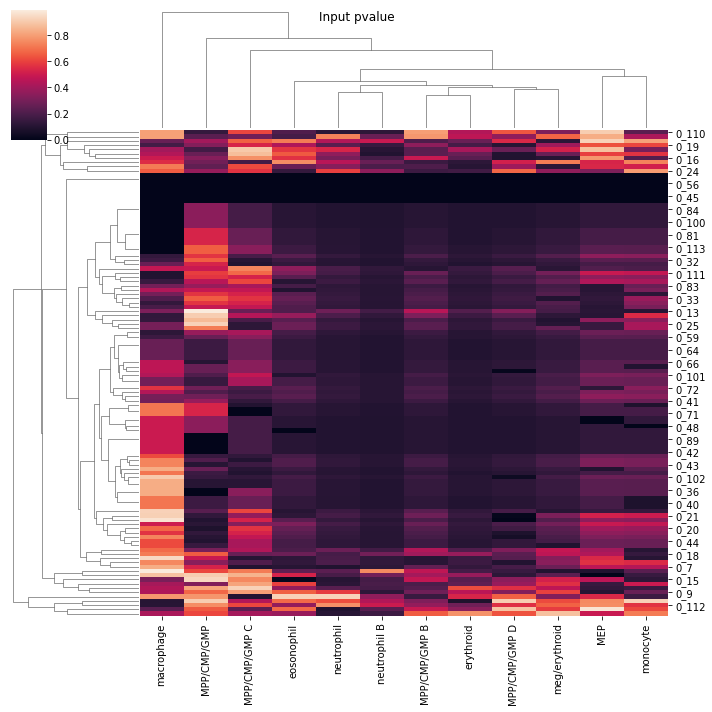

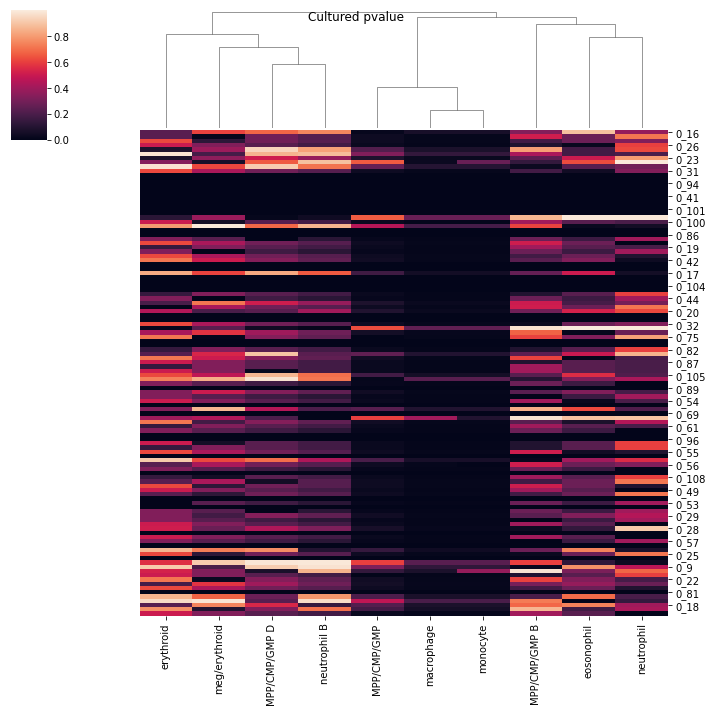

In [16]:
input_hyper = pd.read_csv(in_input_adjHyper_f, index_col=0)
noInput_hyper = pd.read_csv(in_noInput_adjHyper_f, index_col=0) #.loc[input_hyper.index]

all_clones = set(noInput_hyper.index).union(set(input_hyper.index) )

#noInput_hyper.loc[list(all_clones-set(noInput_hyper.index)),:] = 0
noInput_hyper = noInput_hyper.transpose()
if len(all_clones-set(noInput_hyper.columns)) != 0:
    noInput_hyper[list(all_clones-set(noInput_hyper.columns))] = 0
noInput_hyper = noInput_hyper.transpose()
input_hyper = input_hyper.transpose()
print(set(input_hyper.columns))
if len(list(all_clones-set(input_hyper.columns))) != 0:    
    print('here')
    print(list(all_clones-set(input_hyper.columns)))
    input_hyper.loc[:, list(all_clones-set(input_hyper.columns))] = 0
input_hyper = input_hyper.transpose()

#input_hyper.loc[all_clones-set(input_hyper.index),:] = 0
g=sns.clustermap((input_hyper))
g.fig.suptitle("Input pvalue")
inds = g.dendrogram_row.dendrogram["leaves"]
g.fig.savefig(join(outdir, f"input_hyper_padj.pdf"),dpi=300, bbox_inches = "tight")

# g=sns.clustermap(-np.log10(input_hyper))
# g.fig.suptitle("Input(-log 10 pvalue, 1 is p=0.1)")
# inds = g.dendrogram_row.dendrogram["leaves"]
# g.fig.savefig(join(outdir, f"input_hyper_padj.pdf"),dpi=300, bbox_inches = "tight")

#cols = g.dendrogram_col.dendrogram["leaves"]
# g2 = sns.clustermap(-np.log10(noInput_hyper.iloc[inds]), row_cluster=False)
# g2.fig.suptitle("Cultured (-log 10 pvalue, 1 is p=0.1)")
g2 = sns.clustermap((noInput_hyper.iloc[inds]), row_cluster=False)
g2.fig.suptitle("Cultured pvalue")

g2.fig.savefig(join(outdir, f"cultured_hyper_padj.pdf"),dpi=300, bbox_inches = "tight")

In [17]:
# merge_pval = pd.merge(input_df.rename({"value":"p_val"}, axis=1), 
#                       noIn_df.rename({"value":"p_val"}, axis=1), on=["index", "variable", "method"], suffixes=["_input", "_cultured"])
# merge_pval
# merge_pval.to_csv(join(outdir, "shuffle_p_vals.csv"))

# save to combined directory
input_df.to_csv(join(outdir, "input_shuffle_results_pvals.csv"))
noIn_df.to_csv(join(outdir, "noInput_shuffle_results_pvals.csv"))
noInput_hyper.to_csv(join(outdir, "noInput_hypergeo_pvals.csv"))
input_hyper.to_csv(join(outdir, "input_hypergeo_pvals.csv"))

# noInput_hyper.reset_index().melt(id_vars=["index"], value_name="hyper_pval").to_csv(join(outdir, "noInput_hypergeo_pvals.csv"))
# input_hyper.reset_index().melt(id_vars=["index"], value_name="hyper_pval").to_csv(join(outdir, "input_hypergeo_pvals.csv"))


## Get overlapping clones and clusters and use same clone indices from input to noInput

clone_all
clone_min
global_all
global_min


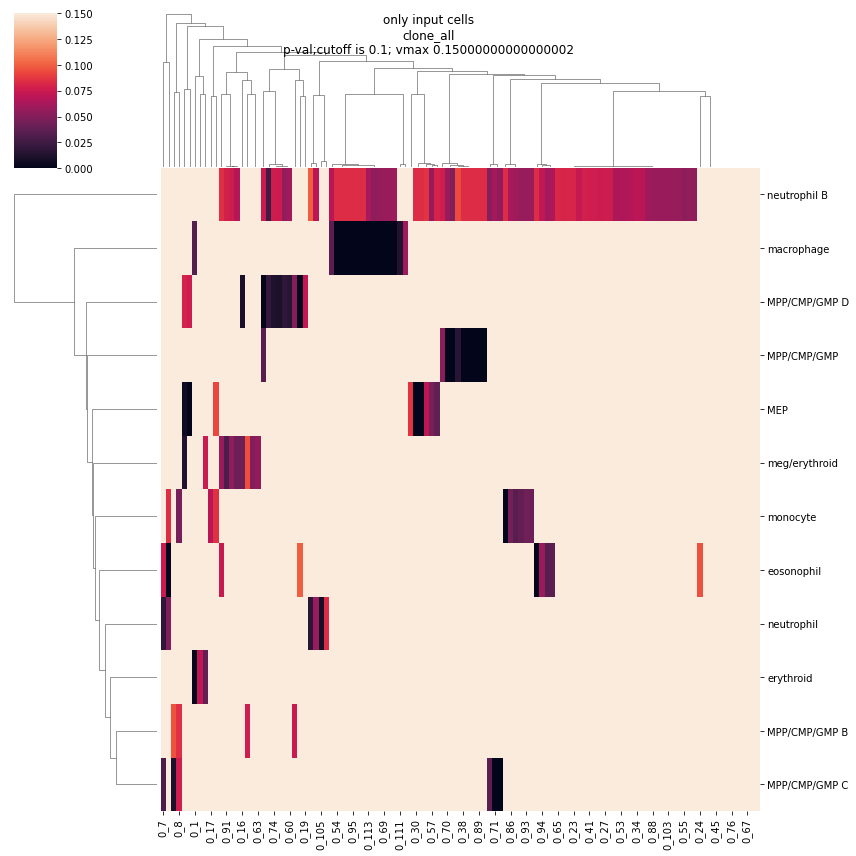

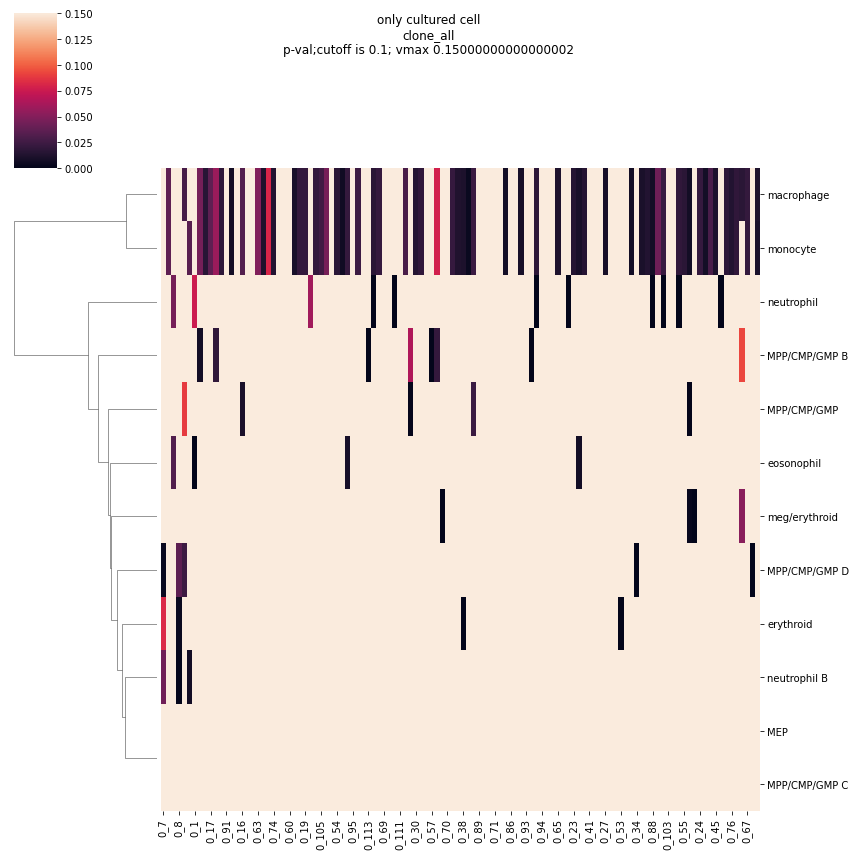

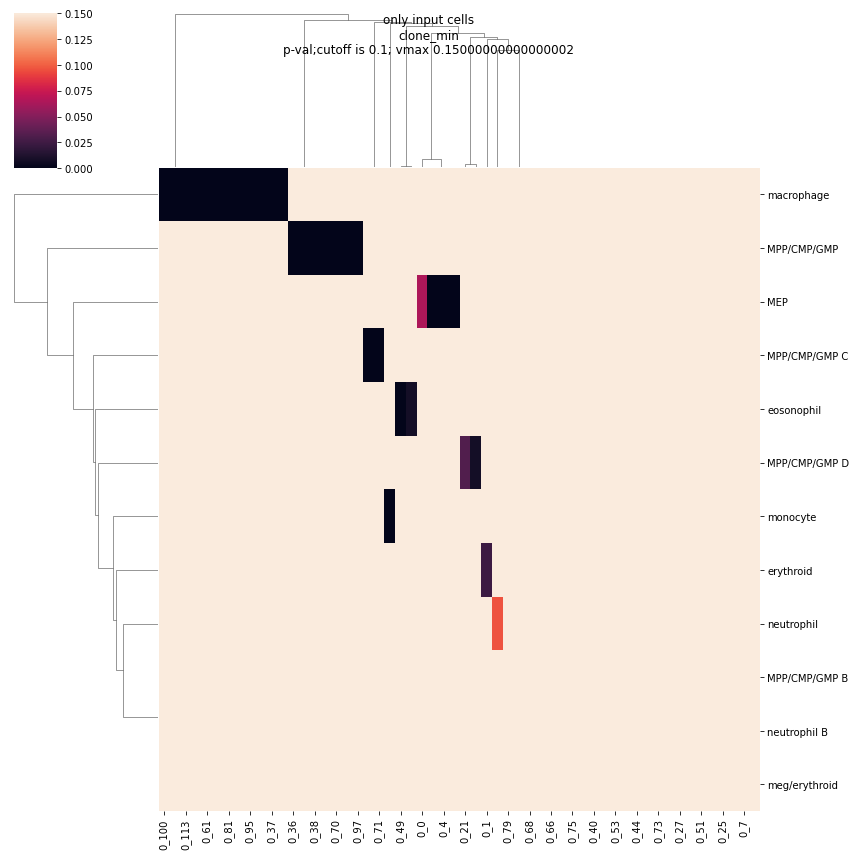

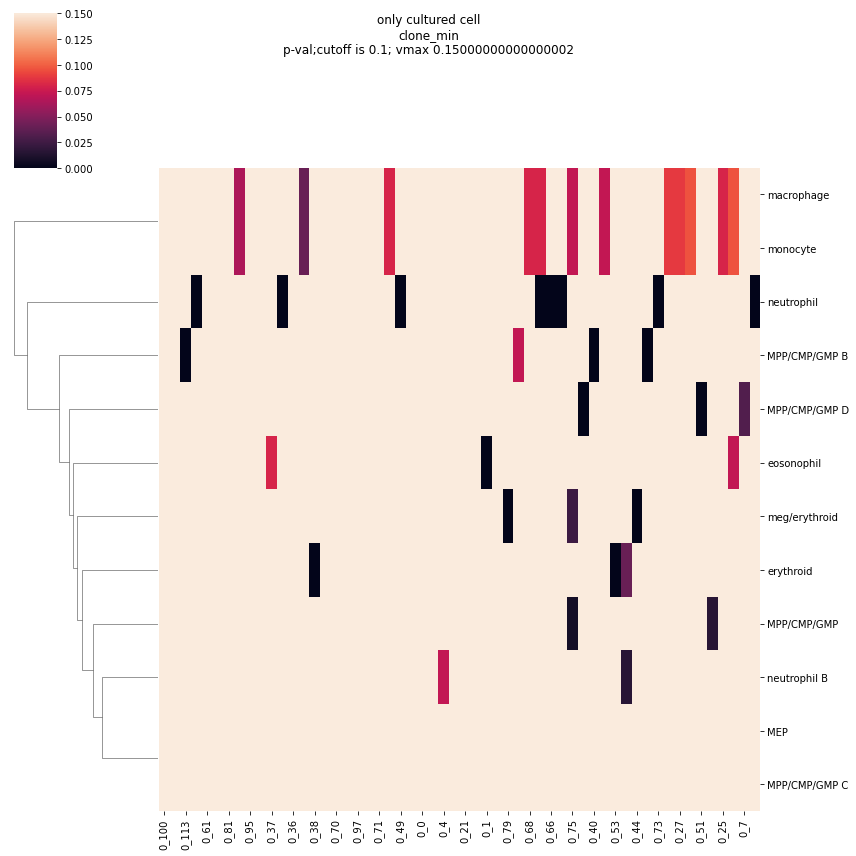

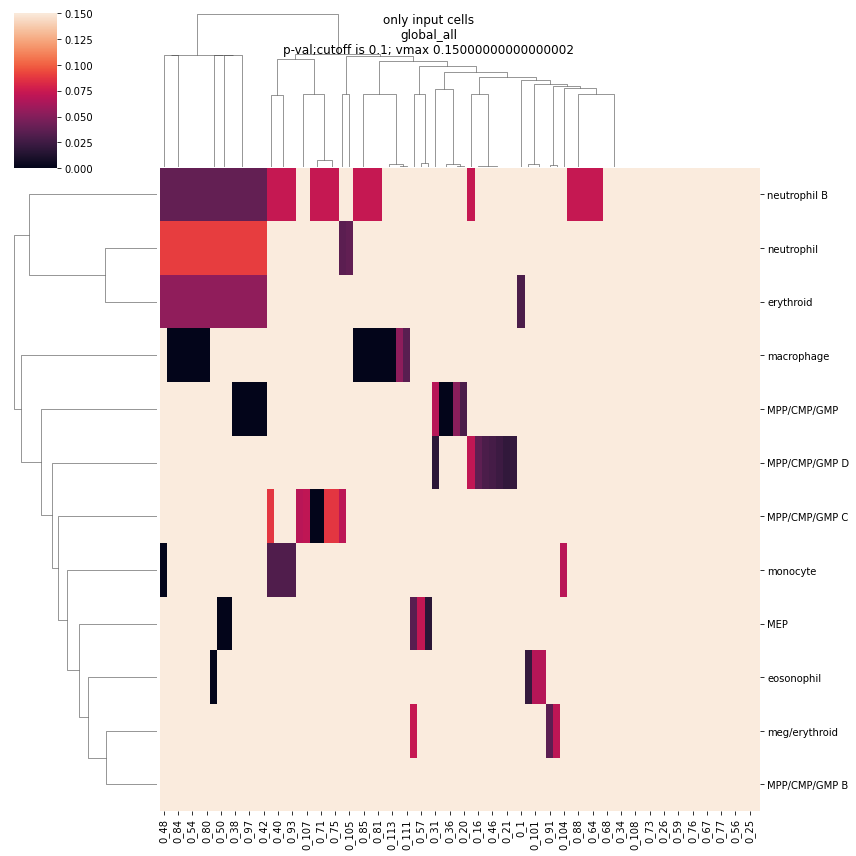

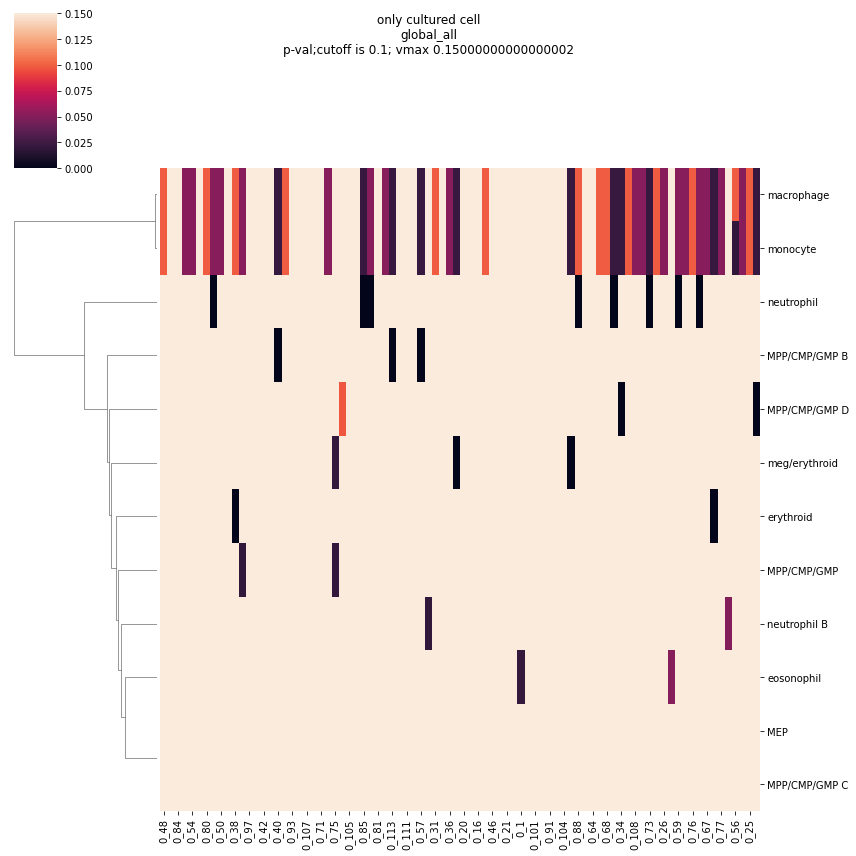

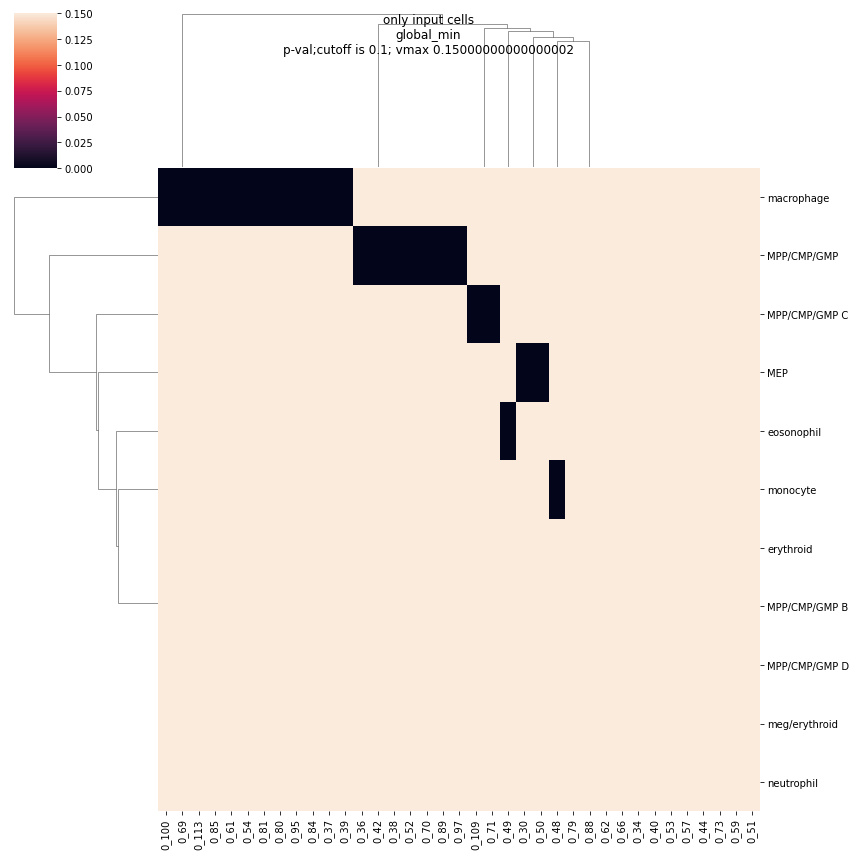

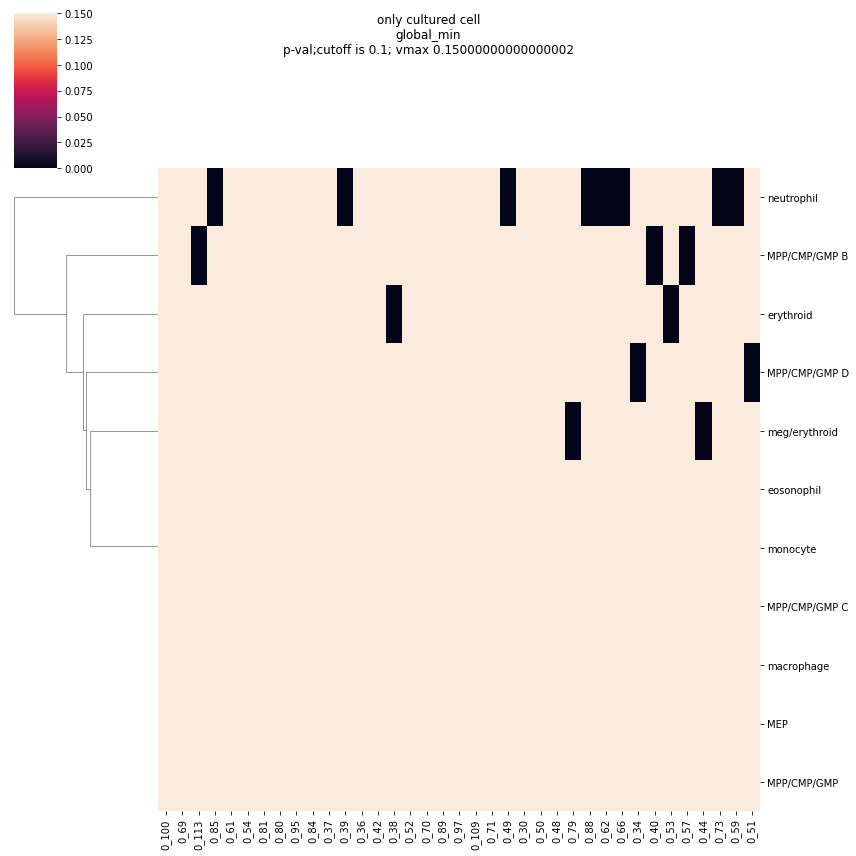

In [18]:
for ind, in_val in input_df[input_df["value"] < p_thresh].groupby("method"):
    print(ind)
    noIn_val = noIn_df.loc[noIn_df["method"] == ind]
    noIn_val = noIn_val.loc[noIn_val["value"]< p_thresh]
    
    noIn_clones = set(noIn_val["index"].values)
    in_clones = set(in_val["index"].values)
    curr_clones = list(noIn_clones.union(in_clones))
    
    noIn_clust = set(noIn_val["variable"].values)
    in_clust = set(in_val["variable"].values)
    curr_clust = list(noIn_clust.union(in_clust))
    
    if (len(curr_clust)==0 or len(curr_clones)==0):
        print('no significant results')
        print(ind)
        continue
     
    
    curr_in_df = pd.DataFrame(index=curr_clones, columns=curr_clust)
    curr_noIn_df = pd.DataFrame(index=curr_clones, columns=curr_clust)

    
    in_val = in_val.set_index(["index", "variable"])
    noIn_val = noIn_val.set_index(["index", "variable"])
    
 
    def get_element_pval(x,y, val):
#         print('val')
#         print(val.head())
        if (y.name, x.name) in val.index:
            return val.loc[(y.name, x.name), "value"]
        else: 
            return 1
         
#     curr_in_df = curr_in_df.apply(lambda x: pd.DataFrame(x).apply(lambda y: in_val.loc[(y.name, x.name), "value"] if (x.name,y.name) in in_val.index else 1, 
#                                                                   axis=1))
    curr_in_df = curr_in_df.apply(lambda x: pd.DataFrame(x).apply(lambda y: get_element_pval(x=x, y=y, val=in_val), axis=1))
    
    curr_noIn_df = curr_noIn_df.apply(lambda x: pd.DataFrame(x).apply(lambda y: get_element_pval(x=x, y=y, val=noIn_val), 
                                                                      axis=1))

    #print(curr_in_df.head())
    
    
    # Transpose both matrices
    curr_noIn_df = curr_noIn_df.transpose()
    curr_in_df = curr_in_df.transpose()
    
    # Plot the input first and then noInput with same clone indices
    
    if (curr_in_df.shape[0] > 1) and (curr_in_df.shape[1] > 1):
        g = sns.clustermap(curr_in_df, vmax=float(p_thresh)+0.05, figsize=(12,12))
        cols = g.dendrogram_col.dendrogram["leaves"]
        g2 = sns.clustermap(curr_noIn_df.iloc[:,cols], col_cluster=False, vmax=float(p_thresh)+0.05, figsize=(12,12))
    else:
        f = plt.figure()
        g = sns.clustermap(curr_in_df, vmax=float(p_thresh)+0.05, row_cluster=False, col_cluster=False)
        g2 = sns.clustermap(curr_noIn_df, vmax=float(p_thresh)+0.05, row_cluster=False, col_cluster=False)

    title = f"{ind}\np-val;cutoff is {p_thresh}; vmax {float(p_thresh)+0.05}"
    g.fig.suptitle("only input cells\n" + title)
    g2.fig.suptitle("only cultured cell\n" + title)
    #g.ax_cbar.set(title=title)  # g.ax_cbar.set(title="-log10 p-value")
    
    g.fig.savefig(join(outdir, f"input_{ind}_shuffle_sig.png"),dpi=300, bbox_inches = "tight")
    
    g2.fig.savefig(join(outdir, f"cultured_{ind}_shuffle_sig.png"),dpi=300, bbox_inches = "tight")
    